# Compare parish boundaries with CCGs

We know that Clinical Commissioning Groups (CCGs) and so Sub-Integrated Care Board Locations (SICBLs) are built up from LSOA boundaries. This notebook checks to see if we can build them up from parish boundaries instead.

## Notebook setup

In [1]:
# For handling the tabular data:
import pandas as pd
# For maps:
import geopandas
import matplotlib.pyplot as plt

# For tracking paths to files:
import os
from dataclasses import dataclass

from mapclassify import greedy  # to assign colours to regions on map.
                                # ^ also requires libpysal.

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    # Directories:
    dir_ons_tabular = '../data_tabular/ons_data/'
    dir_tabular = '../data_tabular/'
    dir_ons_geojson = '../data_geojson/ons_data/'
    dir_output = 'output_data'
    dir_output_images = 'output_images'

    # Tabular data:
    sicbl_icb = 'LOC22_ICB22_NHSER22_EN_LU.csv'
    lad_country = 'Local_Authority_District_to_Country_(December_2022)_Lookup_in_the_United_Kingdom.csv'
    sicbl_lad = 'LSOA11_LOC22_ICB22_LAD22_EN_LU.csv'
    ccg_ambo = 'ambulance_service_info_ccg_lookup.csv'
    ccg_sicbl = 'ccg_stp_sicbl_icb.csv'

    # Boundaries data:
    parish15_geojson = 'PARNCP_Dec_2015_GCB_in_England_and_Wales_V2_2022.geojson'
    ccg15_geojson = 'Clinical_Commissioning_Groups_July_2015_GCB_in_England_2022.geojson'

    # Output:
    df_output = 'parish15_ccg15.csv'
    image_output = 'boundaries_parish15_ccg15.png'

paths = Paths()

## Import region files

In [3]:
gdf_parish = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.parish15_geojson))
gdf_ccg = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg15_geojson))

In [4]:
gdf_ccg.head(3)

,OBJECTID,ccg15cd,ccg15nm,GlobalID,geometry
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",9c545200-287f-46cb-aae9-b7dbd4864dd1,"POLYGON ((385705.500 483950.594, 386027.000 48..."
1,2,E38000002,NHS Ashford CCG,7cb0f335-98b9-4002-93ee-e16a1311439d,"POLYGON ((606227.312 156491.141, 606452.622 15..."
2,3,E38000003,NHS Aylesbury Vale CCG,92a2301c-8bc6-44a4-b09d-0995f98d4fbc,"POLYGON ((472439.907 242170.703, 472451.406 24..."


In [5]:
gdf_parish.head(3)

,OBJECTID,parncp15cd,parncp15nm,parncp15nw,lad15cd,lad15nm,GlobalID,geometry
0,1,E04000001,Blackrod,,E08000001,Bolton,cdccc943-03e0-4a37-be89-3675b2e8c17b,"POLYGON ((358670.000 410970.300, 358798.900 41..."
1,2,E04000002,Horwich,,E08000001,Bolton,f08ff39f-9fd9-4ca3-9375-99e94646ca0e,"POLYGON ((363545.200 409315.700, 363368.100 40..."
2,3,E04000003,Westhoughton,,E08000001,Bolton,11eec5a1-a288-43bc-a1d1-4281d44fa428,"POLYGON ((363545.200 409315.700, 363756.700 40..."


Find parish centroids:

In [6]:
gdf_parish['centroid'] = gdf_parish['geometry'].centroid

In [7]:
gdf_parish.head(3)

,OBJECTID,parncp15cd,parncp15nm,parncp15nw,lad15cd,lad15nm,GlobalID,geometry,centroid
0,1,E04000001,Blackrod,,E08000001,Bolton,cdccc943-03e0-4a37-be89-3675b2e8c17b,"POLYGON ((358670.000 410970.300, 358798.900 41...",POINT (361204.696 410795.666)
1,2,E04000002,Horwich,,E08000001,Bolton,f08ff39f-9fd9-4ca3-9375-99e94646ca0e,"POLYGON ((363545.200 409315.700, 363368.100 40...",POINT (365139.936 411379.388)
2,3,E04000003,Westhoughton,,E08000001,Bolton,11eec5a1-a288-43bc-a1d1-4281d44fa428,"POLYGON ((363545.200 409315.700, 363756.700 40...",POINT (364775.221 406173.005)


Find representative points:

In [8]:
gdf_parish['representative_point'] = gdf_parish['geometry'].representative_point()

In [9]:
gdf_parish.head(3)

,OBJECTID,parncp15cd,parncp15nm,parncp15nw,lad15cd,lad15nm,GlobalID,geometry,centroid,representative_point
0,1,E04000001,Blackrod,,E08000001,Bolton,cdccc943-03e0-4a37-be89-3675b2e8c17b,"POLYGON ((358670.000 410970.300, 358798.900 41...",POINT (361204.696 410795.666),POINT (361046.531 410653.400)
1,2,E04000002,Horwich,,E08000001,Bolton,f08ff39f-9fd9-4ca3-9375-99e94646ca0e,"POLYGON ((363545.200 409315.700, 363368.100 40...",POINT (365139.936 411379.388),POINT (365740.676 411962.250)
2,3,E04000003,Westhoughton,,E08000001,Bolton,11eec5a1-a288-43bc-a1d1-4281d44fa428,"POLYGON ((363545.200 409315.700, 363756.700 40...",POINT (364775.221 406173.005),POINT (365042.362 406187.800)


For each parish point, check if each CCG polygon contains it:

In [10]:
dict_parish_ccg = {}

for ind in gdf_parish.index:
    series_bool = gdf_ccg['geometry'].contains(gdf_parish.loc[ind, 'representative_point'])
    
    ccg_ind = series_bool[series_bool == True].index
    try:
        ccg_name = gdf_ccg.loc[ccg_ind, 'ccg15cd'].values[0]
        parish_name = gdf_parish.loc[ind, 'parncp15cd']
        
        dict_parish_ccg[parish_name] = ccg_name
    except IndexError:
        # This parish isn't in any CCG.
        pass

In [11]:
series_parish_ccg = pd.Series(dict_parish_ccg)
series_parish_ccg.index.name = 'parncp15cd'
series_parish_ccg.name = 'ccg15cd'

In [12]:
series_parish_ccg

parncp15cd
E04000001    E38000016
E04000002    E38000016
E04000003    E38000016
E04000004    E38000158
E04000005    E38000135
               ...    
E43000240    E38000180
E43000241    E38000184
E43000242    E38000196
E43000243    E38000091
E43000244    E38000096
Name: ccg15cd, Length: 10669, dtype: object

In [13]:
gdf_parish = pd.merge(
    gdf_parish, series_parish_ccg,
    left_on='parncp15cd', right_index=True, how='right'
)

In [14]:
gdf_parish.head(3)

,OBJECTID,parncp15cd,parncp15nm,parncp15nw,lad15cd,lad15nm,GlobalID,geometry,centroid,representative_point,ccg15cd
0,1,E04000001,Blackrod,,E08000001,Bolton,cdccc943-03e0-4a37-be89-3675b2e8c17b,"POLYGON ((358670.000 410970.300, 358798.900 41...",POINT (361204.696 410795.666),POINT (361046.531 410653.400),E38000016
1,2,E04000002,Horwich,,E08000001,Bolton,f08ff39f-9fd9-4ca3-9375-99e94646ca0e,"POLYGON ((363545.200 409315.700, 363368.100 40...",POINT (365139.936 411379.388),POINT (365740.676 411962.250),E38000016
2,3,E04000003,Westhoughton,,E08000001,Bolton,11eec5a1-a288-43bc-a1d1-4281d44fa428,"POLYGON ((363545.200 409315.700, 363756.700 40...",POINT (364775.221 406173.005),POINT (365042.362 406187.800),E38000016


Assign a colour to each CCG:

In [15]:
# Assign colour numbers.
# Use 'distance' balance to use as few colours as possible.
gdf_ccg['adjacent_colours'] = greedy(
    gdf_ccg, min_distance=1,
    # balance='distance',
    balance='count',
).astype(str)

In [16]:
# Make a list of colour names:
# Expecting to only need about six colours for this example.
colours = ['Indigo', 'Purple', 'DarkOrchid', 'MediumOrchid', 'Orchid', 'Plum', 'Lavender']

# Make a dictionary of numbers to colours.
# The keys are the numbers in the `adjacent_colours` column:
keys = [f'{i}' for i in range(len(colours))]
colour_map = dict(zip(keys, colours))

In [17]:
# Assign these colours to the regions:
gdf_ccg['colour_str'] = gdf_ccg['adjacent_colours'].map(colour_map)

In [18]:
gdf_ccg.head(3)

,OBJECTID,ccg15cd,ccg15nm,GlobalID,geometry,adjacent_colours,colour_str
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",9c545200-287f-46cb-aae9-b7dbd4864dd1,"POLYGON ((385705.500 483950.594, 386027.000 48...",4,Orchid
1,2,E38000002,NHS Ashford CCG,7cb0f335-98b9-4002-93ee-e16a1311439d,"POLYGON ((606227.312 156491.141, 606452.622 15...",2,DarkOrchid
2,3,E38000003,NHS Aylesbury Vale CCG,92a2301c-8bc6-44a4-b09d-0995f98d4fbc,"POLYGON ((472439.907 242170.703, 472451.406 24...",2,DarkOrchid


Copy over the colours to the parish data:

In [19]:
colour_series = gdf_ccg[['ccg15cd', 'colour_str']]

In [20]:
colour_series

,ccg15cd,colour_str
0,E38000001,Orchid
1,E38000002,DarkOrchid
2,E38000003,DarkOrchid
3,E38000004,DarkOrchid
4,E38000005,Purple
...,...,...
204,E38000210,MediumOrchid
205,E38000211,Plum
206,E38000212,Orchid
207,E38000213,Orchid


In [21]:
gdf_parish = pd.merge(gdf_parish, colour_series, on='ccg15cd', how='left')

In [22]:
gdf_parish.head(3)

,OBJECTID,parncp15cd,parncp15nm,parncp15nw,lad15cd,lad15nm,GlobalID,geometry,centroid,representative_point,ccg15cd,colour_str
0,1,E04000001,Blackrod,,E08000001,Bolton,cdccc943-03e0-4a37-be89-3675b2e8c17b,"POLYGON ((358670.000 410970.300, 358798.900 41...",POINT (361204.696 410795.666),POINT (361046.531 410653.400),E38000016,Orchid
1,2,E04000002,Horwich,,E08000001,Bolton,f08ff39f-9fd9-4ca3-9375-99e94646ca0e,"POLYGON ((363545.200 409315.700, 363368.100 40...",POINT (365139.936 411379.388),POINT (365740.676 411962.250),E38000016,Orchid
2,3,E04000003,Westhoughton,,E08000001,Bolton,11eec5a1-a288-43bc-a1d1-4281d44fa428,"POLYGON ((363545.200 409315.700, 363756.700 40...",POINT (364775.221 406173.005),POINT (365042.362 406187.800),E38000016,Orchid


## Plot map

Make a map where the CCG boundaries are outlined and the parish boundaries are coloured in according to the CCG we think each belongs to.

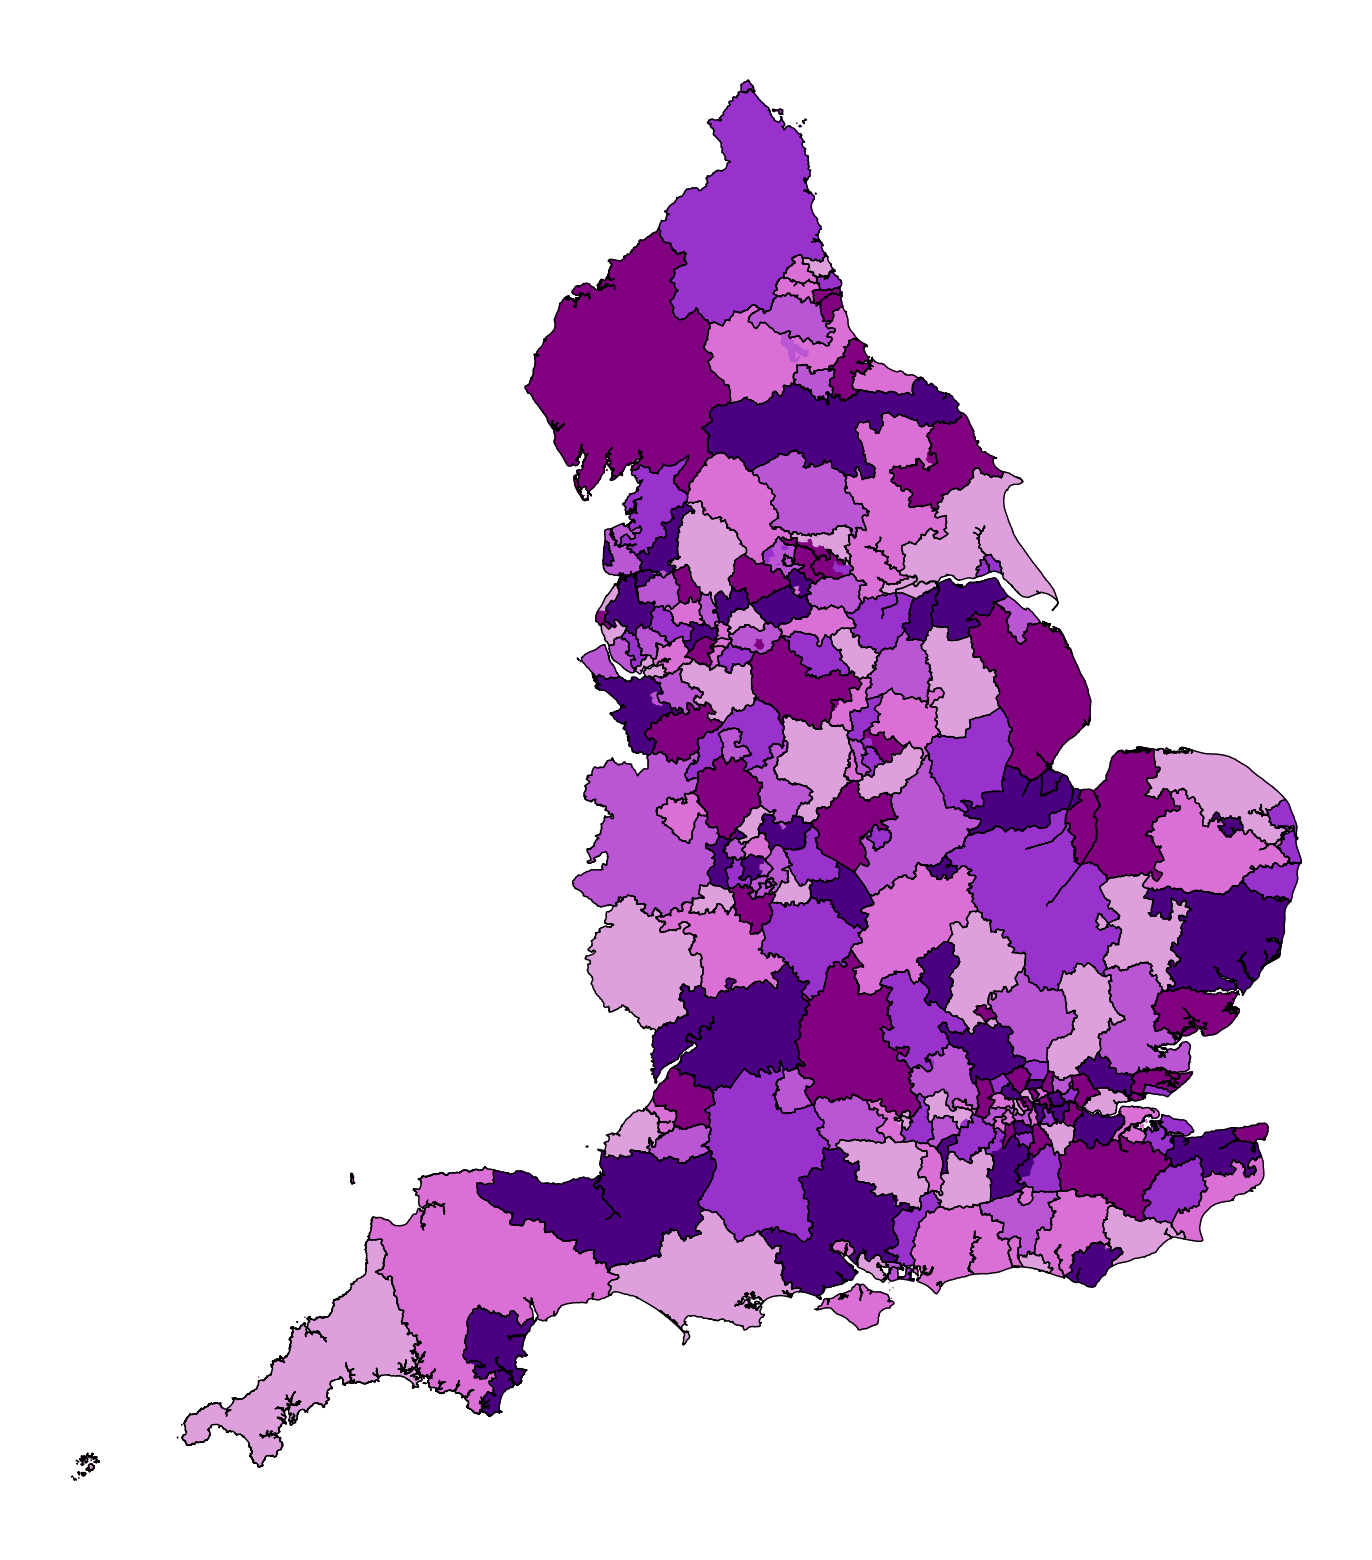

In [23]:
fig, ax = plt.subplots(figsize=(20, 20))

gdf_parish.plot(ax=ax, edgecolor='face', facecolor=gdf_parish['colour_str'])
gdf_ccg.plot(ax=ax, edgecolor='k', facecolor='none')

ax.axis('off')

plt.savefig(os.path.join(paths.dir_output_images, paths.image_output), bbox_inches='tight')
plt.show()